# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

from tqdm import tqdm
import os

# [1]. Reading Data

In [3]:

# using the SQLite Table to read data.
con = sqlite3.connect('/home/imrekcah/Amazon/database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [7]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


positive    38479
negative     7592
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [14]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [15]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [16]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [17]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [18]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [19]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [20]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

<h2><font color='red'>[3.2] Preprocess Review Text</font></h2>

In [21]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:16<00:00, 2835.09it/s]


In [22]:
final['Text'].values[0]

'My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.'

In [23]:
preprocessed_reviews[0]

'dogs loves chicken product china wont buying anymore hard find chicken products made usa one isnt bad good product wont take chances till know going china imports'

In [24]:
final['CleanedText']=preprocessed_reviews

<h2><font color='red'>[3.2] Preprocess Summary</font></h2>

In [25]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 46071/46071 [00:10<00:00, 4577.58it/s]


In [26]:
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,positive,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product available victor traps unreal course t...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,positive,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,used victor fly bait seasons ca not beat great...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


In [27]:
preprocessed_summary[0]

'made china'

In [57]:
final['Summary'].values[0]

'made in china'

# TSNE Fucntion Declaration

# [4] Featurization

## [4.1] BAG OF WORDS

In [58]:


# Taking equal sample of negative and positive reviews to keep it balanced.
# If it is not balanced then there is chance that one class lebel can dominant other class label which might be sever probelm sometimes.
positive_points = final[final['Score'] == 'positive'].sample(n=2500)
negative_points = final[final['Score'] == 'negative'].sample(n=2500)

# Concatenating both of above
total_points = pd.concat([positive_points, negative_points])



In [59]:
total_points.shape

(5000, 11)

In [60]:
%%time
# Initializing vectorizer for bigram
count_vect = CountVectorizer()

# Initializing standard scaler
std_scaler = StandardScaler(with_mean=False)

# Creating count vectors and converting into dense representation
sample_points_bow=total_points['CleanedText']
sample_points_bow=count_vect.fit_transform(sample_points_bow)
sample_points_bow=std_scaler.fit_transform(sample_points_bow)
sample_points_bow=sample_points_bow.todense()

# Storing class label in variable
labels = total_points['Score']

# Getting shape
print(sample_points_bow.shape, labels.shape)



(5000, 14599) (5000,)
CPU times: user 266 ms, sys: 172 ms, total: 439 ms
Wall time: 469 ms


## [4.2] Bi-Grams and n-Grams.

In [61]:
%%time
#bi-gram, tri-gram and n-gram

    #removing stop words like "not" should be avoided before building n-grams
    # count_vect = CountVectorizer(ngram_range=(1,2))
    # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    # you can choose these numebrs min_df=10, max_features=5000, of your choice


# Initializing vectorizer for bigram
count_vect = CountVectorizer(ngram_range=(1,2),min_df=10,max_features=5000)

# Initializing standard scaler
std_scaler = StandardScaler(with_mean=False)

# Creating count vectors and converting into dense representation
sample_points_bow_bigram=total_points['CleanedText']
sample_points_bow_bigram=count_vect.fit_transform(sample_points_bow_bigram)
sample_points_bow_bigram=std_scaler.fit_transform(sample_points_bow_bigram)
sample_points_bow_bigram=sample_points_bow_bigram.todense()

# Storing class label in variable
labels = total_points['Score']

# Getting shape
print(sample_points_bow_bigram.shape, labels.shape)
    
    

(5000, 3434) (5000,)
CPU times: user 784 ms, sys: 67.8 ms, total: 852 ms
Wall time: 855 ms


## [4.3] TF-IDF

In [62]:
%%time

# Initializing tf-idf vectorizer for bigram
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))

tfidf_data = total_points['CleanedText']
tfidf_data = tfidf_vect.fit_transform(tfidf_data)
tfidf_data = tfidf_data.todense()

CPU times: user 1.4 s, sys: 396 ms, total: 1.8 s
Wall time: 1.2 s


In [63]:
print(tfidf_data.shape, labels.shape)

(5000, 158305) (5000,)


## [4.4] Word2Vec

In [64]:
# Getting text from Review
w2v_points = total_points['Text']
w2v_labels = labels.copy()

In [65]:
import re
def cleanhtml(sentence):
    cleantext = re.sub('<.*>', '', sentence)
    return cleantext

def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|#|@|.|,|)|(|\|/]', r'', sentence)
    return cleaned

In [66]:
# Creating list of sentences
sent_list = []
for sent in w2v_points:
    sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                sentence.append(cleaned_words.lower())
            else:
                continue
    sent_list.append(sentence)

In [67]:
print(sent_list[3])

['i', 'share', 'some', 'of', 'the', 'views', 'of', 'other', 'reviewers', 'particularly', 'the', 'fact', 'that', 'this', 'product', 'is', 'from', 'thailand', 'upon', 'opening', 'the', 'first', 'can', 'of', 'the', 'sesame', 'chicken', 'i', 'was', 'struck', 'by', 'how', 'high', 'the', 'quality', 'looked', 'the', 'shredded', 'chicken', 'looked', 'as', 'if', 'it', 'had', 'been', 'plucked', 'from', 'the', 'bone', 'as', 'well', 'as', 'the', 'yummy', 'smell', 'i', 'was', 'tempted', 'to', 'heat', 'some', 'up', 'and', 'try', 'it', 'myself', 'resisting', 'that', 'urge', 'i', 'served', 'it', 'to', 'my', 'cats', 'and', 'they', 'went', 'after', 'it', 'like', 'white', 'on', 'rice', 'lapping', 'every', 'bit', 'of', 'it', 'up', 'and', 'i', 'have', 'some', 'picky', 'catsall', 'in', 'all', 'my', 'cats', 'give', 'the', 'product', 'a', 'big', 'however', 'like', 'another', 'reviewer', 'i', 'would', 'tend', 'to', 'give', 'this', 'out', 'as', 'a', 'special', 'treat', 'versus', 'daily', 'feeding', 'for', 'that

In [68]:
# Initializing model for words occur atleast 5 times
w2v_model = gensim.models.Word2Vec(sent_list, min_count=5, size=50, workers=4)

# Applying model for word2vec
w2v_words = w2v_model[w2v_model.wv.vocab]

In [69]:
print("Number of words occur min 5 times: ", len(w2v_words))

Number of words occur min 5 times:  3719


In [70]:
print(w2v_words.shape)


(3719, 50)


In [71]:


# Getting 10 similar words
w2v_model.wv.most_similar("not")


[('what', 0.8973689079284668),
 ('but', 0.8636063933372498),
 ('sure', 0.8632974624633789),
 ('bad', 0.8600655794143677),
 ('really', 0.8429595232009888),
 ('worth', 0.8419363498687744),
 ('definitely', 0.8368018865585327),
 ('familiar', 0.8357836008071899),
 ('say', 0.8306367993354797),
 ('how', 0.8272437453269958)]

### Avg Word2Vec

In [72]:
# Producing average word to vec vectors
import numpy as np
sent_vectors = []
for sent in sent_list:
    sent_vec = np.zeros(200)
    cnt_words = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.nan_to_num(sent_vectors)

In [73]:
print(sent_vectors.shape)

(5000, 200)


## TF-IDF Word2Vec

In [74]:
%%time

tfidf_feat = tfidf_vect.get_feature_names()
tfidf_w2v_vectors = []
row = 0
for sent in sent_list:
    sent_vec = np.zeros(200)
    weight_sum = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec*tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_vectors.append(sent_vec)
    row += 1

CPU times: user 1.59 s, sys: 26.3 ms, total: 1.61 s
Wall time: 1.46 s


# [5] Applying TSNE

<ol> 
    <li> you need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

In [75]:
def TSNEPlots(sample_points,labels,defaultParams):
    from sklearn.manifold import TSNE

    tsne_data = sample_points
    tsne_labels = labels

    # Initializing with most explained variance
    if defaultParams==True:
        model = TSNE(n_components=2, random_state=15)
    else:
        model = TSNE(n_components=2, random_state=15, perplexity=20, n_iter=2000)
        
    # Fitting model
    tsne_data = model.fit_transform(tsne_data)

    # Adding labels to the data point
    tsne_data = np.vstack((tsne_data.T, tsne_labels)).T

    # Creating data frame
    tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))

    # Plotting graph for class labels
    sb.FacetGrid(tsne_df, hue='label', height=5).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    if defaultParams==True:
        plt.title("TSNE with default parameters")
    else:
        plt.title("TSNE with perplexity: 20, n_iter:2000")
        
    plt.xlabel("Dim_1")
    plt.ylabel("Dim_2")
    plt.show()


## TSNE FOR BOW (unary)

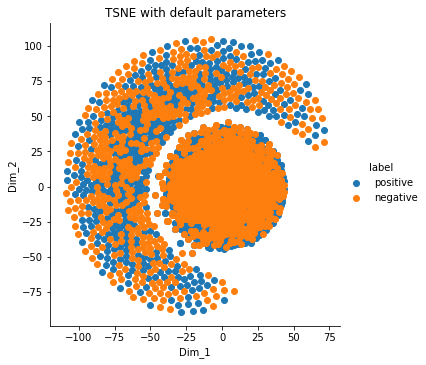

CPU times: user 11min 59s, sys: 4.95 s, total: 12min 4s
Wall time: 12min 1s


In [76]:
%%time
TSNEPlots(sample_points_bow,labels,True)

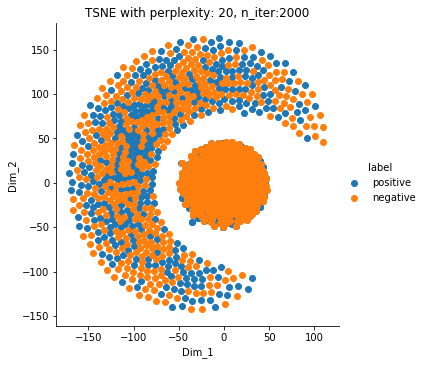

CPU times: user 13min 4s, sys: 9.85 s, total: 13min 14s
Wall time: 13min 11s


In [77]:
%%time
TSNEPlots(sample_points_bow,labels,False)

## TSNE FOR BOW (bigram)

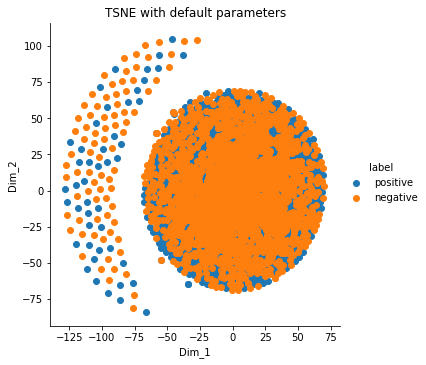

CPU times: user 4min 17s, sys: 5.18 s, total: 4min 22s
Wall time: 4min 20s


In [78]:
%%time
TSNEPlots(sample_points_bow_bigram,labels,True)

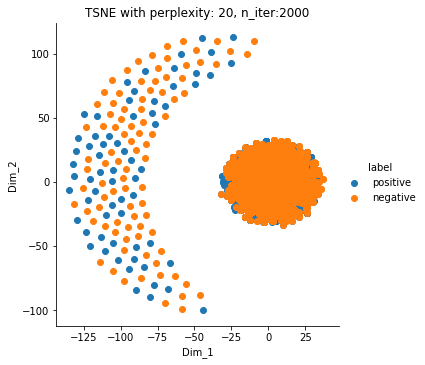

CPU times: user 5min 15s, sys: 10.2 s, total: 5min 25s
Wall time: 5min 23s


In [79]:
%%time
TSNEPlots(sample_points_bow_bigram,labels,False)

## TSNE for TF-IDF

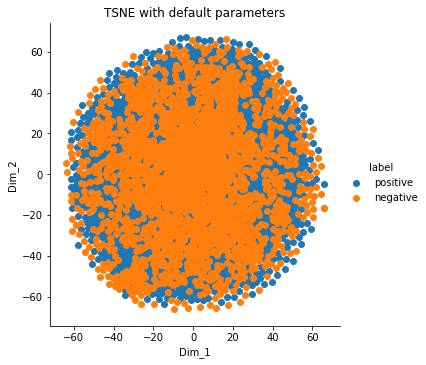

CPU times: user 1h 48min 39s, sys: 6.21 s, total: 1h 48min 45s
Wall time: 1h 48min 43s


In [80]:
%%time
TSNEPlots(tfidf_data,labels,True)

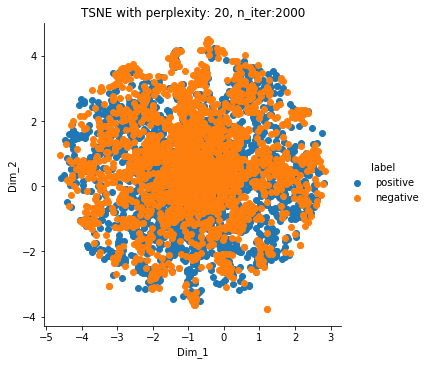

CPU times: user 1h 49min 24s, sys: 8.12 s, total: 1h 49min 32s
Wall time: 1h 49min 30s


In [81]:
%%time
TSNEPlots(tfidf_data,labels,False)

## TSNE for Avg Word2VEC

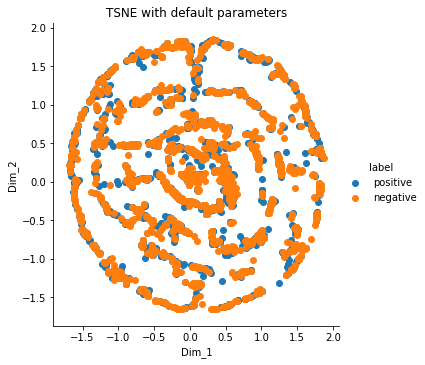

CPU times: user 3min 6s, sys: 5.91 s, total: 3min 12s
Wall time: 3min 10s


In [82]:
%%time
TSNEPlots(sent_vectors,labels,True)

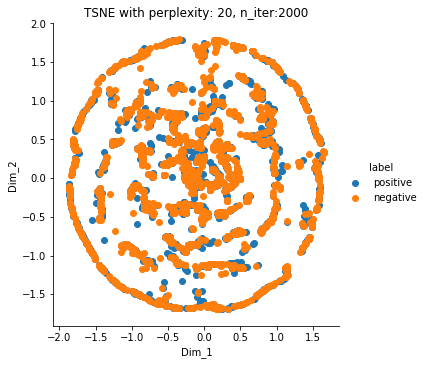

CPU times: user 1min 8s, sys: 4.22 s, total: 1min 12s
Wall time: 1min 10s


In [83]:
%%time
TSNEPlots(sent_vectors,labels,False)

## TSNE for TF-IDF Word2Vec 

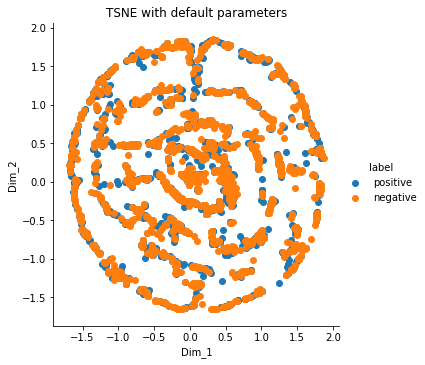

CPU times: user 3min 2s, sys: 5.51 s, total: 3min 8s
Wall time: 3min 5s


In [84]:
%%time
TSNEPlots(tfidf_w2v_vectors,labels,True)

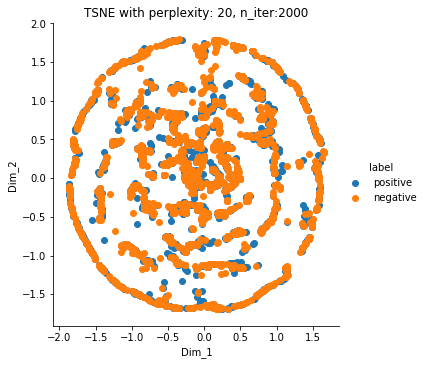

CPU times: user 1min 8s, sys: 3.98 s, total: 1min 12s
Wall time: 1min 9s


In [85]:
%%time
TSNEPlots(tfidf_w2v_vectors,labels,False)